In [7]:
import numpy as np

import pandas as pd

import diffprivlib.tools as dp

from sklearn.preprocessing import LabelEncoder

from tqdm.notebook import trange
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

/Users/cl/.pyenv/versions/3.7.5/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [8]:
na_values={
    'capital-gain': 99999,
    'capital-loss': 99999,
    'hours-per-week': 99,
    'workclass': '?',
    'native-country': '?',
    'occupation': '?'}

private_df = pd.read_csv('./data/adult_with_no_native_country.csv',
                         skipinitialspace=True,
                         na_values=na_values)
private_df.set_index('index', inplace=True)

synthetic_df = pd.read_csv('./out/correlated_attribute_mode/sythetic_data.csv',
                           skipinitialspace=True)
synthetic_df.set_index('index', inplace=True)


In [9]:
categorical_attributes = private_df.dtypes.loc[private_df.dtypes=='O'].index.values
numerical_attributes = [col for col in private_df.columns if col not in categorical_attributes]
categorical_attributes

array(['workclass', 'education', 'martial-status', 'occupation',
       'relationship', 'race', 'sex', 'income'], dtype=object)

In [10]:
(pd.merge(private_df, synthetic_df,
         on=list(private_df.columns.values),
         how='left',
         indicator='Exists').Exists=='both').sum()

0

In [11]:
for col in categorical_attributes:
    le = LabelEncoder()
    private_df[col] = le.fit_transform(private_df[col].fillna('unk'))
    synthetic_df[col] = le.transform(synthetic_df[col].fillna('unk'))

In [15]:
def get_overlap(row, other, ncols):
    rst = row == other
    rst = rst.sum(axis=1)
    rst = rst * 100 / ncols
    return min(rst), np.mean(rst), max(rst)

priv_np = private_df.values
ncols = priv_np.shape[1]
synth_np = synthetic_df.values

overlap = []
for n in trange(priv_np.shape[0]):
    row = priv_np[n,:]
    overlap.append(get_overlap(row, synth_np, ncols))

<AxesSubplot:>

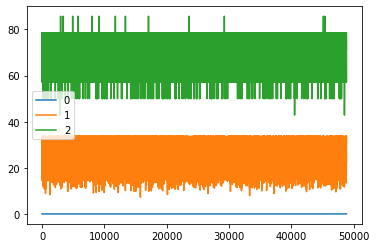

In [30]:
pd.DataFrame(np.vstack(overlap), columns=['min', 'mean', 'max']).plot()

<AxesSubplot:>

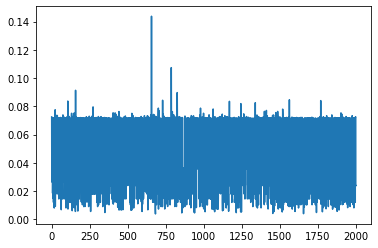

In [100]:
p_cols = []
for name, target in private_df.loc[:2000,:].iterrows():
    p_col = []
    for col in target.index:
        # print(col)
        cnt = private_df[col].loc[private_df[col]==target[col]].shape[0]
        if cnt == 0:
            p = 0
        else:
            p = 1 / cnt
        p_col.append(p)
    p_cols.append(p_col)
pd.Series(np.vstack(p_cols).sum(axis=1) / target.shape[0]).plot()

14

<AxesSubplot:>

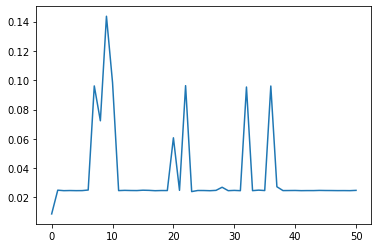

In [98]:
p_cols = []
for name, target in private_df.loc[:50,:].iterrows():
    p_col = []
    for col in target.index:
        # print(col)
        cnt = synthetic_df[col].loc[synthetic_df[col]==target[col]].shape[0]
        if cnt == 0:
            p = 0
        else:
            p = 1 / cnt
        p_col.append(p)
    p_cols.append(p_col)
pd.Series(np.vstack(p_cols).sum(axis=1) / target.shape[0]).plot()